## 아기울음 소리 분류 모델: ResNet

데이터 전처리 과정에서 각 음성의 성조, 진폭, 등에 따른 패턴을 추출하였다.

각 상태(hungry, sad, ...etc)에 따른 서로 다른 패턴의 특징을 효과적으로 감지하고 분류하기 위해 대규모 이미지 분류 모델인 ResNet50을 사용하였다.

본 문서는 아기울음 소리 원인 분류를 위해 ResNet50 모델의 전이학습을 수행하는 내용을 담고 있다.

> ResNet50 모델의 정확도는 93%로 최종 서비스에 사용된 모델이다.


In [ ]:
# Load packages
import os
import sys
import glob
import random
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from skimage.transform import resize
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [ ]:
# 경로 설정
main_dir = '/Users/jaewone/developer/tensorflow/baby-cry-classification'
data_dir = os.path.join(main_dir, 'data')
model_dir = os.path.join(main_dir, 'model', 'reset', 'resnet.h5')

sys.path.append(main_dir)

In [ ]:
# 하이퍼 파라미터
batch_size = 32
steps_per_epoch = 160
epochs = 85

Epoch 1/85
160/160 [==============================] - 594s 4s/step - loss: 1.7189 - accuracy: 0.3219 - val_loss: 1.5798 - val_accuracy: 0.3862
Epoch 2/85
160/160 [==============================] - 644s 4s/step - loss: 1.5215 - accuracy: 0.4193 - val_loss: 1.4653 - val_accuracy: 0.4487
Epoch 3/85
160/160 [==============================] - 657s 4s/step - loss: 1.4778 - accuracy: 0.4363 - val_loss: 1.5122 - val_accuracy: 0.4300
Epoch 4/85
160/160 [==============================] - 653s 4s/step - loss: 1.4071 - accuracy: 0.4631 - val_loss: 1.4065 - val_accuracy: 0.4863
Epoch 5/85
160/160 [==============================] - 664s 4s/step - loss: 1.3645 - accuracy: 0.4828 - val_loss: 1.3682 - val_accuracy: 0.4794
Epoch 6/85
160/160 [==============================] - 674s 4s/step - loss: 1.3409 - accuracy: 0.4949 - val_loss: 1.3106 - val_accuracy: 0.5031
Epoch 7/85
160/160 [==============================] - 675s 4s/step - loss: 1.3151 - accuracy: 0.5078 - val_loss: 1.2856 - val_accuracy: 0.5100

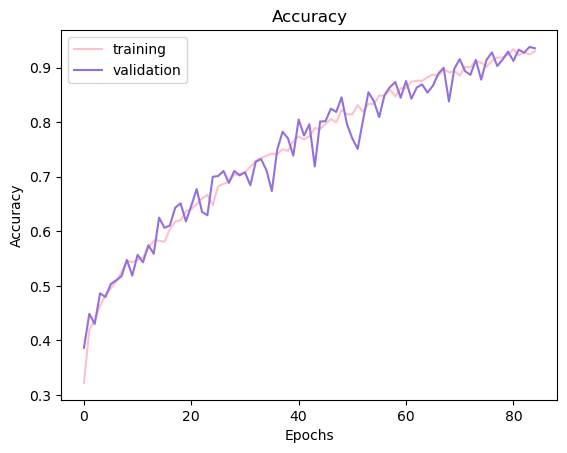

/Users/jangminjun/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
# TensorFlow GPU 메모리 동적 관리 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 데이터셋 디렉토리 경로 설정
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

# ResNet-50 모델 불러오기 및 커스터마이징
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(128, 862, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# 최종 모델 정의
model = Model(inputs=base_model.input, outputs=predictions)

# ResNet-50 기본 모델 레이어를 고정하여 학습되지 않도록 함
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(
    learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


# 데이터셋 및 레이블 생성 함수
def generate_data(data_dir, class_labels, batch_size, is_training=True):
    while True:
        batch_X = []
        batch_labels = []
        data_to_use = os.listdir(data_dir)

        if is_training:
            data_to_use = train_test_split(
                data_to_use, test_size=0.2, random_state=42)[0]
        else:
            data_to_use = train_test_split(
                data_to_use, test_size=0.2, random_state=42)[1]

        for _ in range(batch_size):
            label_idx = np.random.randint(num_classes)
            label = class_labels[label_idx]
            class_dir = os.path.join(data_dir, label)

            # 수정된 부분: class_dir 내에 있는 파일들을 이용해 무작위로 파일을 선택합니다.
            filename = np.random.choice(os.listdir(class_dir))
            file_path = os.path.join(class_dir, filename)

            y, sr = librosa.load(file_path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(
                y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
            mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
            RATIO = 862 / 64
            mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                         anti_aliasing=True, mode='reflect')
            mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
            batch_X.append(mel_spec_dB_stacked)
            batch_labels.append(label_idx)

        batch_X = np.array(batch_X)
        batch_labels = to_categorical(batch_labels, num_classes=num_classes)
        yield batch_X, batch_labels


# 훈련 데이터셋 생성 함수
train_data_generator = generate_data(
    data_dir, class_labels, batch_size, is_training=True)

# 테스트 데이터셋 생성 함수
test_data_generator = generate_data(
    data_dir, class_labels, batch_size, is_training=False)

# 모델 학습
history = model.fit(
    train_data_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=test_data_generator,
    validation_steps=50)

# 학습 결과 시각화
plt.plot(history.history['accuracy'], label='training', color='pink')
plt.plot(history.history['val_accuracy'],
         label='validation', color='mediumpurple')  # 검증 데이터 정확도 추가
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


model.save(model_dir)

### 생성된 모델을 통해 정확도를 측정을 수행한다.


In [8]:
# 난수 초기 시드 설정
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# 모델 로드
loaded_model = tf.keras.models.load_model(model_dir)


# 데이터셋 디렉토리 경로 설정
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

# .h5 파일에서 모델 로드
model = load_model(model_dir)


# 데이터셋 생성 함수
def generate_data(paths, class_labels, batch_size):
    num_classes = len(class_labels)
    while True:
        batch_X = []
        batch_labels = []

        for _ in range(batch_size):
            path = np.random.choice(paths)
            label = os.path.basename(os.path.dirname(path))

            y, sr = librosa.load(path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(
                y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
            mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
            RATIO = 862 / 64
            mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                         anti_aliasing=True, mode='reflect')
            mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
            batch_X.append(mel_spec_dB_stacked)
            label_idx = class_labels.index(label)
            batch_labels.append(label_idx)

        batch_X = np.array(batch_X)
        batch_labels = to_categorical(batch_labels, num_classes=num_classes)
        yield batch_X, batch_labels


# 데이터 로드 및 train-test split 수행
data_paths = glob.glob(os.path.join(data_dir, "*/*"))
# TensorFlow 난수 시드 설정
tf.random.set_seed(42)
train_paths, test_paths = train_test_split(
    data_paths, test_size=0.2, random_state=42)

# 배치 크기 설정
batch_size = 32

# 학습 및 테스트 데이터 생성 함수
train_data_generator = generate_data(train_paths, class_labels, batch_size)
test_data_generator = generate_data(test_paths, class_labels, batch_size)

# 테스트 데이터 설정
num_test_samples = 1000
steps = num_test_samples // batch_size

# 모델 성능 평가
loss, accuracy = model.evaluate(test_data_generator, steps=steps, verbose=1)

print(f"Loss: {loss:.5f}")
print(f"Accuracy: {accuracy:.5f}")

31/31 [==============================] - 117s 4s/step - loss: 0.3286 - accuracy: 0.9335
Loss: 0.32859
Accuracy: 0.93347
